In [1]:
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
from fontsettings import set_font_settings

In [2]:
set_font_settings()

### 2 Сравнение групп платящих игроков
-------------------------------------------
В мобильной игре около 10% игроков совершает платежи в первый месяц с момента 
установки игры (база расчета - 500 игроков). 
Геймдизайнеры разработали обновление которое по их экспертной оценке должно 
увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или 
опровергнуть их гипотезу.
Геймдизайнеры разработали обновление которое по их экспертной оценке должно 
увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или 
опровергнуть их гипотезу.
1. Опишите оптимальный по вашему мнению дизайн эксперимента
2. Рассчитайте длительность эксперимента при условии что каждый день в игру 
приходит около 100 новых игроков.
3. Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и 
рассчитайте 95% HDI / CI.
4. Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без 
эффекта), рассчитайте силу эффекта, HDI / CI и ваши выводы для каждого 
варианта.
5. Решите задачу 2 разными подходами: frequentist / bayesian
Необходимо все ответы сопроводить комментариями почему вы выбрали ту или иную 
методику расчета, алгоритм и т.д

### Решение (частотный подход):
1. Рандомизированное разделение пользователей на две группы: тестовою и контрольную. Пользователи в первой категории получат экспериментальную версию продукта, а пользователи второй — обычную.

2. Рассчет длительности эксперимента (в предположении нормальности):

In [21]:
def calc_sample_size(bcr, bcr_, alpha=0.05, beta=0.2):
    """
    Calculcate sample size for ab-test with required
    first and second order errors
    
    Parameters
    ----------
    bcr : real number
        basic conversion rate
    bcr_ : real number
        basic conversion rate after changes
    alpha : real number
        first order error
    beta : real number
        second order error

    Returns
    -------
    n_elements : real number
        required sample size
    """
    distr = stats.norm()
    # quantille values
    z_halfalpha = distr.ppf(1 - alpha / 2)
    z_beta = distr.ppf(1 - beta)

    # minimum detectable effect
    mde = bcr_ - bcr
    part1 = z_halfalpha * np.sqrt(2 * bcr * (1 - bcr))
    part2 = z_beta * np.sqrt(bcr * (1 - bcr) + bcr_ * (1 - bcr_))
    n_elements = np.power((part1 + part2) / mde, 2)
    # round to the nearest whole number
    n_elements = int(n_elements)
    return n_elements

In [22]:
def calc_duration(required_size, daily_inflow):
    """
    Calculate the test duration 
    """
    n_days = int(required_size / daily_inflow)
    return n_days

In [56]:
# conversions rate
bcr_ = 0.11
bcr = 0.1
# daily_inflow
daily_inflow = 100
# required errors
alpha, beta = 0.05, 0.1

n_players = calc_sample_size(bcr, bcr_, alpha, beta)
n_players_total = 2 * n_payers
n_days = calc_duration(n_players, daily_inflow)

In [48]:
print(f'Required number of players for each group: {n_players}')
print(f'Required test duration: {n_days} days')

Required number of players for each group: 19239
Required test duration: 192 days


3. Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и рассчитайте 95% HDI / CI.

In [282]:
class Players:

    def __init__(self, bcr):
        self.bcr = bcr

    
    def rvs(self, n_players):
        sample_tmp = np.random.binomial(1, self.bcr, n_players)
        self.n_players = n_players
        self.n_payers = np.sum(sample_tmp)
        self.a, self.b = self.n_payers + 1, n_players - self.n_payers + 1
        self.distr_apriori = stats.beta(self.a, self.b)
        self.sample = self.distr_apriori.rvs(n_players)

    
    def ci(self, alpha):
        self.ci_lb = stats.beta.ppf(alpha/2, self.n_payers, self.n_players-self.n_payers+1)
        self.ci_ub = stats.beta.ppf(1-(alpha/2), self.n_payers+1, self.n_players-self.n_payers)
        return self.ci_lb, self.ci_ub

In [283]:
# fix the seed value
np.random.seed(42)

# payers and non-payers
players = Players(bcr)
players.rvs(n_players_total)

print(f'The part of paying players is: {np.round(players.n_payers / players.n_players, 4)}')

# credible interval bounds
ci_lb, ci_ub = players.ci(alpha)

The part of paying players is: 0.0985


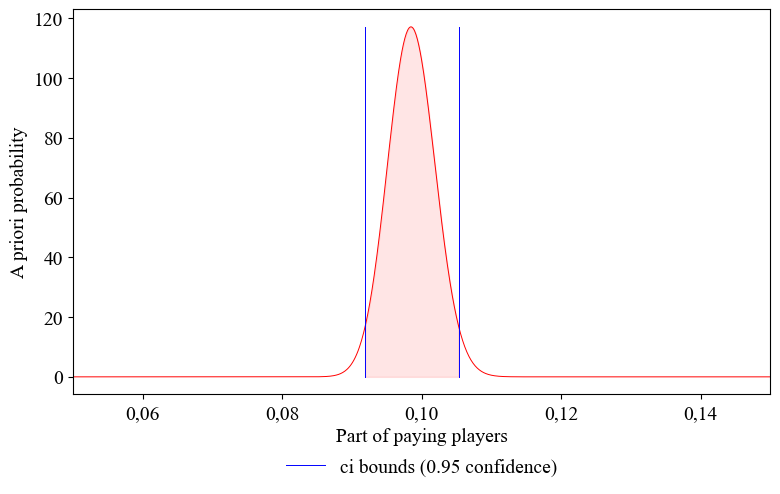

In [284]:
pp = np.linspace(0, 1, 10001)

# plot the result
fig, ax = plt.subplots(figsize=(9, 5))
dmax = players.distr_apriori.pdf(pp).max()
ax.plot(pp, players.distr_apriori.pdf(pp), lw=0.7, color='r')
# credible interval bounds
ax.plot([ci_lb, ci_lb], [0, dmax], lw=0.7, color='b', label=f'ci bounds ({1-alpha} confidence)')
ax.plot([ci_ub, ci_ub], [0, dmax], lw=0.7, color='b')
ax.fill_between(pp, players.distr_apriori.pdf(pp), where = (pp > ci_lb) & (pp < ci_ub), color='r', alpha=0.1)

# plot settings
ax.set(xlabel='Part of paying players', ylabel='A priori probability', xlim=(0.05, 0.15));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);

In [315]:
print(f'Credible interval is: ({np.round(ci_lb, 4)}, {np.round(ci_ub, 4)}) with confidence probability equal to {1 - alpha}')

Credible interval is: (0.0919, 0.1054) with confidence probability equal to 0.95


4. Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без эффекта), рассчитайте силу эффекта, HDI / CI и ваши выводы для каждого варианта.

In [316]:
control_players = Players(bcr)
control_players.rvs(n_players)

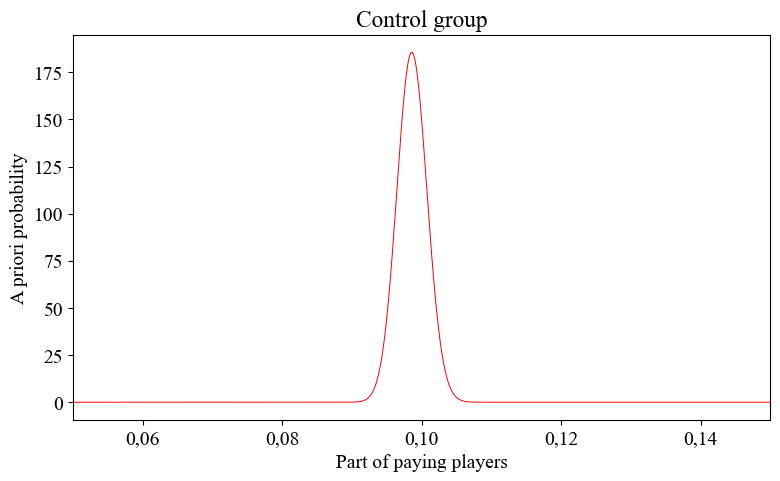

In [317]:
pp = np.linspace(0, 1, 10001)

# plot the result
fig, ax = plt.subplots(figsize=(9, 5))
dmax = control_players.distr_apriori.pdf(pp).max()
ax.plot(pp, control_players.distr_apriori.pdf(pp), lw=0.7, color='r')

# plot settings
ax.set(xlabel='Part of paying players', ylabel='A priori probability', xlim=(0.05, 0.15));
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);
plt.title('Control group');

    4.1 Хуже

In [318]:
bcr_bad = 0.03
bad_test_players = Players(bcr_bad)
bad_test_players.rvs(n_players)

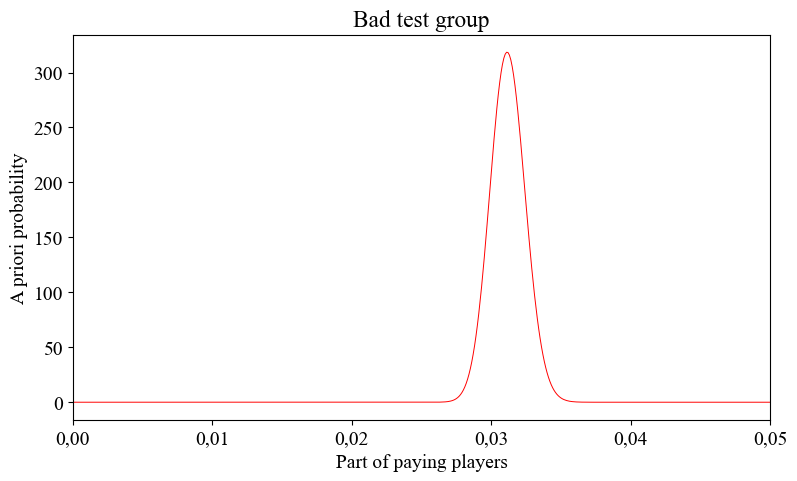

In [319]:
pp = np.linspace(0, 1, 10001)

# plot the result
fig, ax = plt.subplots(figsize=(9, 5))
dmax = bad_test_players.distr_apriori.pdf(pp).max()
ax.plot(pp, bad_test_players.distr_apriori.pdf(pp), lw=0.7, color='r')

# plot settings
ax.set(xlabel='Part of paying players', ylabel='A priori probability', xlim=(0, 0.05));
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);
plt.title('Bad test group');

    4.2 Без изменений

In [320]:
bcr_equal = 0.1
equal_test_players = Players(bcr_equal)
equal_test_players.rvs(n_players)

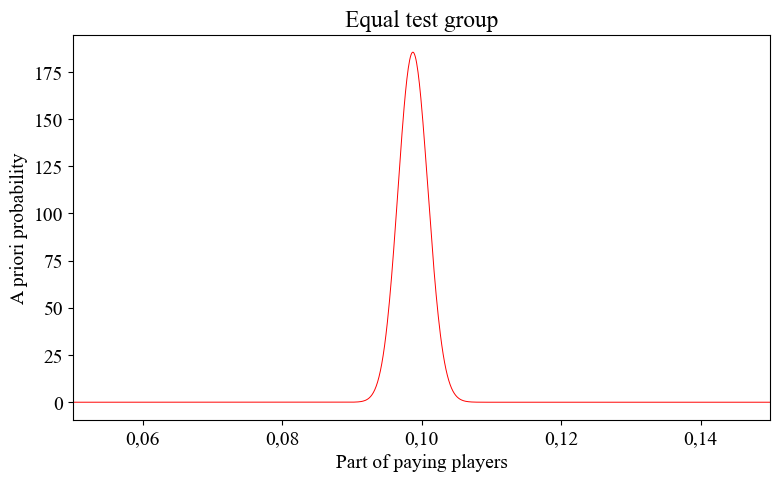

In [321]:
pp = np.linspace(0, 1, 10001)

# plot the result
fig, ax = plt.subplots(figsize=(9, 5))
dmax = equal_test_players.distr_apriori.pdf(pp).max()
ax.plot(pp, equal_test_players.distr_apriori.pdf(pp), lw=0.7, color='r')

# plot settings
ax.set(xlabel='Part of paying players', ylabel='A priori probability', xlim=(0.05, 0.15));
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);
plt.title('Equal test group');

    4.3 Лучше

In [347]:
bcr_best = 0.2
best_test_players = Players(bcr_best)
best_test_players.rvs(n_players)

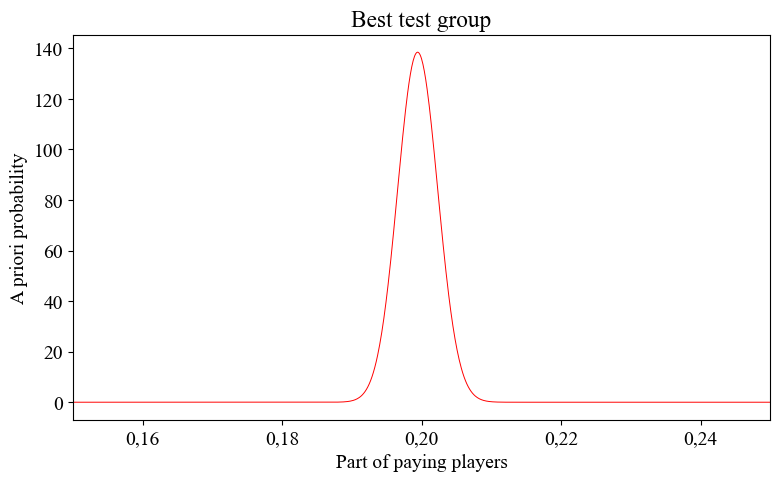

In [348]:
pp = np.linspace(0, 1, 10001)

# plot the result
fig, ax = plt.subplots(figsize=(9, 5))
dmax = best_test_players.distr_apriori.pdf(pp).max()
ax.plot(pp, best_test_players.distr_apriori.pdf(pp), lw=0.7, color='r')

# plot settings
ax.set(xlabel='Part of paying players', ylabel='A priori probability', xlim=(0.15, 0.25));
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);
plt.title('Best test group');

In [349]:
control = control_players.sample
bad = bad_test_players.sample
equal = equal_test_players.sample
best = best_test_players.sample

Group 'best':
  Effect size: 39.5262
  HDI interval: [0.1938, 0.2051]

Group 'bad':
  Effect size: -38.2109
  HDI interval: [0.0287, 0.0335]

Group 'equal':
  Effect size: 0.0830
  HDI interval: [0.0948, 0.1033]



C:\Users\Danis Garipov\AppData\Local\Temp\ipykernel_14808\2428752661.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control, best, bad, equal],


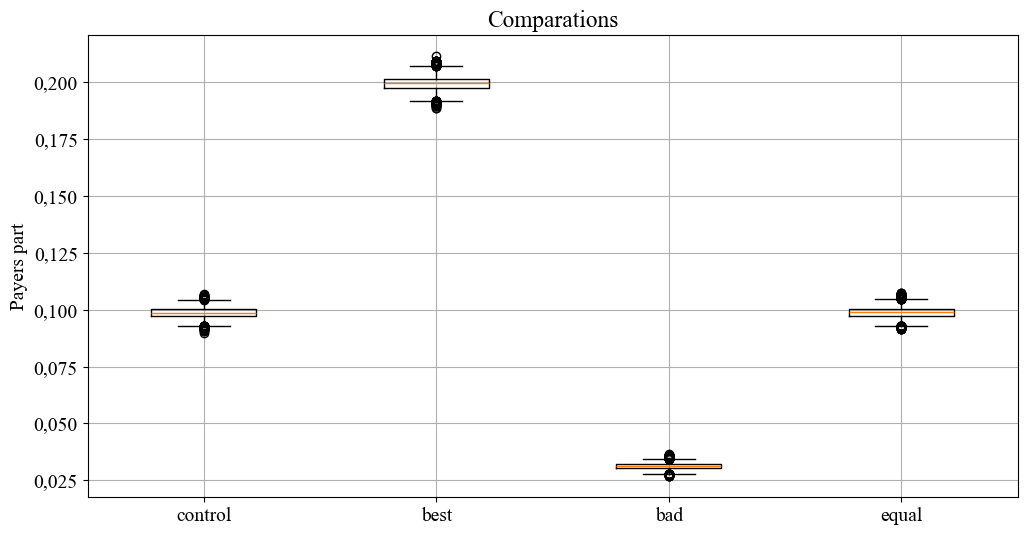

In [371]:
def hdi(data, p_confidence=0.95):
    """
    Calculate hdi interval bounds
    """
    sorted_data = np.sort(data)
    n = len(sorted_data)
    cmi = int(np.floor(p_confidence * n))

    intervals = [(sorted_data[i + cmi] - sorted_data[i], (sorted_data[i], sorted_data[i + cmi]))
                 for i in range(n - cmi)]

    min_length, hdi_interval = min(intervals)
    return hdi_interval


def effect_size(group1, group2):
    """
    Calculate effect size
    """
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    std1 = np.std(group1, ddof=1)
    std2 = np.std(group2, ddof=1)
    n1 = len(group1)
    n2 = len(group2)
    
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_std

# Calculations
groups = {
    "best": best,
    "bad": bad,
    "equal": equal
}

results = {}

for label, group in groups.items():
    effect = effect_size(group, control)
    hdi_interval = hdi(group)
    
    results[label] = {
        'Effect Size': effect,
        'HDI': hdi_interval,
        '95% CI': ci
    }

# Print the result
for label, metrics in results.items():
    print(f"Group '{label}':")
    print(f"  Effect size: {metrics['Effect Size']:.4f}")
    print(f"  HDI interval: [{metrics['HDI'][0]:.4f}, {metrics['HDI'][1]:.4f}]")
    print("")

# Plot the result
plt.figure(figsize=(12, 6))
plt.boxplot([control, best, bad, equal], 
            labels=['control', 'best', 'bad', 'equal'])
plt.title('Comparations')
plt.ylabel('Payers part')
plt.grid()
plt.show()


Выводы: группа $best$ показывает статистически значимое увеличение среднего числа платящих пользователей, группа $bad$ - уменьшение. Статистического значимого эффекта в группе $equal$ не наблюдается